# kNearestNeighbor Algorithm

#### Ishita Kapur, UTA ID: 1001753123

k-Nearest Neighbor(k-NN) is an instance-based supervised learning algorithm which classifies a new instance by comparing it with already stored instances in the memory that have already been seen in training. k being the number of neighbors which are considered.

This implementation of the algorithm is built from scratch. It includes **10-fold cross validation** and **vectorized distance computation**. It compares the performance of the algorithm(accuracy) using different distance metrics and different k(number of neighbor) values.

The **datasets** used for comparing the model accuracies are as follows:

    1. Hayes-Roth Dataset
    2. Car Evaluation Dataset
    3. Breast Cancer Dataset

The different **distance metrics** used for comparing the model accuracies are as follows:

    1. Vectorized Computation: (using numpy)
        * Euclidean Distance
        * Manhattan Distance
        * Minkowski Distance
    2. 2-Loop Computation:
        * Hamming Distance

The different **k values** used for comparing the model accuracies are as follows:

    1, 3, 5, 7, 9

### Preprocessing data

Most machine learning models work with only numeric data. In the **Hayes-Roth Dataset** the column **'name'** needs to be dropped, because even though it is numeric data it is unique for each row in the data set and it is just like an identity and does not provide information related to the class. The **Car Evaluation Dataset** and **Breast Cancer Dataset** have categorical textual data. The data was converted into numeric using preprocessing. The columns had to be reindexed because the model assumes the last column to be the **class** label. The code used for preprocessing data is in the **PreprocessData.ipynb Notebook** in the same folder as this Notebook. The preprocessed datasets are used for comparing model accuracies.

### Implementation

Required python libraries are imported.

In [1]:
import pandas as pd
import numpy as np

**Vectorized Computation Functions**

These functions are much faster than the traditional 2-loop computations for distances. These functions work on Numpy ndarrays. It computes a distance matrix using the train and test datasets. The class is then predicted by finding the most common class from the k nearest neighbors(least distance, more similarity).

In [2]:
def vectorizedEuclidean(train, test, train_label, no_neighbors):
    num_train = train.shape[0]
    num_test = test.shape[0]
    dists = np.zeros((num_test, num_train))
    dists = np.sqrt(np.sum(np.square(test[:,np.newaxis,:] - train), axis=2))
    predicted = predictClass(dists, no_neighbors, train_label)
    return predicted

def vectorizedManhattan(train, test, train_label, no_neighbors):
    num_train = train.shape[0]
    num_test = test.shape[0]
    dists = np.absolute(np.sum(test[:,np.newaxis,:] - train, axis=2))
    predicted = predictClass(dists, no_neighbors, train_label)
    return predicted

def vectorizedMinkowski(train, test, train_label, no_neighbors):
    num_train = train.shape[0]
    num_test = test.shape[0]
    dists = np.zeros((num_test, num_train))
    dists = np.sum(np.power((test[:,np.newaxis,:] - train), 5), axis=2, dtype=np.complex)**(1/5)
    predicted = predictClass(dists, no_neighbors, train_label)
    return predicted

**2-loop Distance Computation**

The functions defined below are the traditional way of computing distances using 2-loops. These are slower and takes very long for larger dataset, for e.g: Car Evaluation Dataset. These have been implemented but not all have been used in the model accuracy comparison. The function for *Hamming Distance* is the only one being used from the ones listed below.

In [3]:
def euclideanDistance(datarow_1, datarow_2):
    dist = 0
    for i in range(len(datarow_1) - 1):
        dist = dist + np.square(datarow_1[i] - datarow_2[i])
    return np.sqrt(dist)

def manhattanDistance(datarow_1, datarow_2):
    dist = 0
    for i in range(len(datarow_1) - 1):
        dist = dist + abs(datarow_1[i] - datarow_2[i])
    return dist

def minkowskiDistance(datarow_1, datarow_2):
    dist = 0
    order = 5
    for i in range(len(datarow_1) - 1):
        dist = dist + pow(abs(datarow_1[i] - datarow_2[i]), order)
    return pow(dist, (1/order))

def hammingDistance(a, b):
    r = (1 << np.arange(8))[:,None]
    return np.count_nonzero((np.bitwise_xor(a,b) & r) != 0)

**k-fold**

Following is the function for splitting the datasets into k-folds to perform k-fold cross validation.

In [4]:
def splitDatasetKFolds(dataset, n_folds):
    shuffled = dataset.sample(frac=1)
    result = np.array_split(shuffled, n_folds)
    return result

**Predicting the class**

The function below predicts the class for the test dataset by using the vectorized distance computation. It find the most common class among the k nearest neighbors.

In [5]:
def predictClass(a, N, train_label):
    idx = np.argpartition(a, N, axis=1)[:, :N]
    indices = idx.ravel()
    out = train_label[indices]
    output = out.reshape(idx.shape)
    predicted_class = []
    for row in output:
        elements, counts = np.unique(row, return_counts=True)
        predicted_class.append(elements[np.argmax(counts)])
    return predicted_class

Other helper functions used to predict the test data classes are defined below. These have been defined to compute the distances, find the neighbors and finally pedict the class of the test data. Functions to compute accuracy and mean accuracy have also been defined below.

In [6]:
def getNeighbors(train, testrow, no_neighbors, distanceMetric):
    distances = list()
    for trainrow in train:
        row_dist = distanceMetric(trainrow, testrow)
        distances.append((trainrow, row_dist))
    distances.sort(key=lambda attr: attr[1])
    neighbors = list()
    for i in range(no_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

def makePrediction(train, testrow, no_neighbors, distanceMetric):
    neighbors = getNeighbors(train, testrow, no_neighbors, distanceMetric)
    output = [row[-1] for row in neighbors]
    prediction = max(set(output), key = output.count)
    return prediction

def kNN(train, test, no_neighbors, distanceMetric):
    predictions = list()
    for row in test:
        output = makePrediction(train, row, no_neighbors, distanceMetric)
        predictions.append(output)
    return predictions

def computeAccuracy(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return (correct / len(actual)) * 100.0

def meanAccuracy(accuracies):
    return (sum(accuracies)/float(len(accuracies)))

Function for performing kNN using 10-fold cross validation.

In [7]:
def performKNN(dataset, algorithm, n_folds, no_neighbors, distanceMetric, accuracies_df):
    cv_split = splitDatasetKFolds(dataset, n_folds)
    accuracies = list()
    for i in range(n_folds):
        cv_train = cv_split.copy()
        cv_test = cv_split[i]
        del cv_train[i]
        cv_train = pd.concat(cv_train, sort=False)
        train_set = cv_train.iloc[:,:-1].to_numpy()
        train_label = cv_train.iloc[:,-1].to_numpy()
        test_set = cv_test.iloc[:,:-1].to_numpy()
        cv_train_list = cv_train.iloc[:,:-1].to_numpy().tolist()
        cv_test_rows = cv_test.iloc[:,:-1].to_numpy().tolist()
        actual_cv_test_label = cv_test.iloc[:,-1].to_list()
        for key, metric in distanceMetric.items():
            if not key.startswith('Vect'):
                predicted = kNN(cv_train_list, cv_test_rows, no_neighbors, metric)
                accuracy = computeAccuracy(actual_cv_test_label, predicted)
                accuracies_df.loc[no_neighbors, key] = accuracy
            else:
                predicted = metric(train_set, test_set, train_label, no_neighbors)
                accuracy = computeAccuracy(actual_cv_test_label, predicted)
                accuracies_df.loc[no_neighbors, key] = accuracy
    return accuracies

The function below calls the performKNN function defined above to compute accuracies for different distance metrics and k-values. It computes the mean accuracy for all the distance metrics and displays the **best distance metric** and the **best k value** for any particular dataset. It also displays a plot for k-value(x-axis) vs accuracy(y-axis) for the different distance metrics.

In [8]:
def performAlgorithm(data):
    
    neigh = (1, 3, 5, 7, 9)
    dist_metric = {'Vectorized Euclidean': vectorizedEuclidean, 'Vectorized Manhattan': vectorizedManhattan, 'Vectorized Minkowski': vectorizedMinkowski, 'Hamming Distance': hammingDistance}
    metrics = list(dist_metric.keys())
    accuracies_df = pd.DataFrame(index=neigh,columns=metrics)
    for n in neigh:
        accuracies = performKNN(data, kNN, 10, n, dist_metric, accuracies_df)
    print('\n\033[1mAccuracy for different k and different distance metrics: \033[0m')
    print(accuracies_df)
    
    print('\n\033[1mMean Accuracies for different Distance Metrics: \033[0m')
    mean_accuracy = accuracies_df.mean()
    print(mean_accuracy)
    
    best_metric = mean_accuracy.idxmax()
    print('\nDistance metric which performed best is \033[1m' + best_metric + '\033[0m with Mean Accuracy \033[1m{:.2f}\033[0m'.format(mean_accuracy.max()))
    
    best_accuracy = accuracies_df[best_metric].max()
    print('\nMaximum Accuracy : \033[1m{:.2f}\033[0m'.format(best_accuracy))
    best_k = accuracies_df[accuracies_df[best_metric]==best_accuracy].index.values[0]
    print('\nBest k value is : \033[1m' + str(best_k) + '\033[0m')
    
    print('\nPlot comparing accuracies for different Distance Metrics:')
    compare = accuracies_df.plot.line()

## kNN on Hayes-Roth Dataset

Hayes Roth Dataset: 
      hobby  age  educational_level  marital_status  class
0        2    1                  1               2      1
1        2    1                  3               2      2
2        3    1                  4               1      3
3        2    4                  2               2      3
4        1    1                  3               4      3
..     ...  ...                ...             ...    ...
127      1    1                  4               3      3
128      2    1                  2               1      1
129      1    2                  1               2      2
130      1    2                  2               1      2
131      3    1                  1               2      1

[132 rows x 5 columns]

Accuracy for different k and different distance metrics: 
  Vectorized Euclidean Vectorized Manhattan Vectorized Minkowski  \
1              53.8462              46.1538              38.4615   
3              69.2308              61.5385              61.538

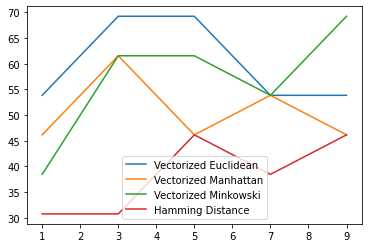

In [9]:
data = pd.read_csv('Datasets/hayes_roth/hayes-roth-no-name.data', header=None, names=['hobby', 'age', 'educational_level', 'marital_status', 'class'])
print('\033[1mHayes Roth Dataset: \033[0m\n', data)
performAlgorithm(data)

## kNN on Breast Cancer Dataset

Breast Cancer Dataset: 
      age  menopause  tumor_size  inv_nodes  node_caps  deg_malig  breast  \
0      1          1           1          1          1          1       1   
1      2          1           2          1          1          2       2   
2      2          1           2          1          1          2       1   
3      3          2           3          1          1          2       2   
4      2          1           4          1          1          2       2   
..   ...        ...         ...        ...        ...        ...     ...   
281    1          1           1          1          1          2       1   
282    1          1           2          1          1          1       1   
283    3          2           2          1          1          3       2   
284    2          2           1          4          1          1       1   
285    4          2           1          4          1          1       1   

     breast_quad  irradiat  class  
0              1         1

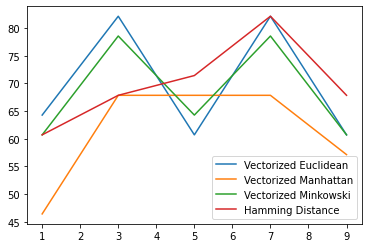

In [10]:
data = pd.read_csv('Datasets/breast_cancer/breast-cancer-number.data', header=None, names=['age', 'menopause', 'tumor_size', 'inv_nodes', 'node_caps', 'deg_malig', 'breast', 'breast_quad', 'irradiat', 'class'], index_col=False)
print('\033[1mBreast Cancer Dataset: \033[0m\n', data)
performAlgorithm(data)

## kNN on Car Evaluation Dataset

Car Evaluation Dataset: 
       buying  maint  doors  persons  lug_boot  safety  class
0          1      1      1        1         1       1      1
1          1      1      1        1         1       2      1
2          1      1      1        1         1       3      1
3          1      1      1        1         2       1      1
4          1      1      1        1         2       2      1
...      ...    ...    ...      ...       ...     ...    ...
1723       4      4      4        3         2       2      4
1724       4      4      4        3         2       3      3
1725       4      4      4        3         3       1      1
1726       4      4      4        3         3       2      4
1727       4      4      4        3         3       3      3

[1728 rows x 7 columns]

Accuracy for different k and different distance metrics: 
  Vectorized Euclidean Vectorized Manhattan Vectorized Minkowski  \
1              86.0465              66.8605               69.186   
3              92.4419

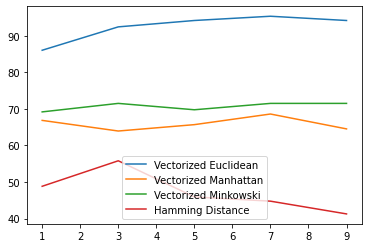

In [11]:
data = pd.read_csv('Datasets/car_evaluation/car-eval-number.data', header=None, names=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class'], index_col=False)
print('\033[1mCar Evaluation Dataset: \033[0m\n', data)
performAlgorithm(data)